In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

from pydrake.geometry.optimization import HPolyhedron
from pydrake.solvers import MosekSolver

from gcs.bezier import BezierGCS
from gcs.linear import LinearGCS
from models.env_2d import obstacles, vertices

savefig = 0

# Environment setup

In [2]:
x_start = np.array([.2, .2])
x_goal = np.array([4.8, 4.8])

x_min = np.min(np.vstack(vertices), axis=0)
x_max = np.max(np.vstack(vertices), axis=0)

def make_hpolytope(V):
    ch = ConvexHull(V)
    return HPolyhedron(ch.equations[:, :-1], - ch.equations[:, -1])

regions = [make_hpolytope(V) for V in vertices]

def environment_setup():
    
    plt.figure(figsize=(3, 3))
    plt.axis('square')
    
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    
    tick_gap = .2
    n_ticks = lambda x_min, x_max: round((x_max - x_min) / tick_gap) + 1
    x_ticks = np.linspace(x_min[0], x_max[0], n_ticks(x_min[0], x_max[0]))
    y_ticks = np.linspace(x_min[1], x_max[1], n_ticks(x_min[1], x_max[1]))
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    
    label_gap = .5
    keep_label = lambda t: np.isclose(t % label_gap, 0) or np.isclose(t % label_gap, label_gap)
    x_labels = [int(t) if keep_label(t) else '' for t in x_ticks]
    y_labels = [int(t) if keep_label(t) else '' for t in y_ticks]
    plt.gca().set_xticklabels(x_labels)
    plt.gca().set_yticklabels(y_labels)
    
    plt.grid()

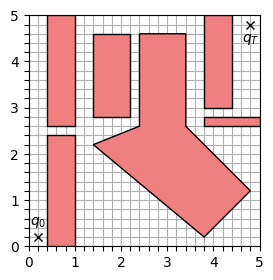

In [3]:
environment_setup()

plt.plot(*x_start, 'kx')
plt.plot(*x_goal, 'kx')

plt.text(.2, .35, '$q_0$', ha='center', va='bottom')
plt.text(4.8, 4.65, '$q_T$', ha='center', va='top')

if savefig:
    plt.savefig('setup.pdf', bbox_inches='tight')

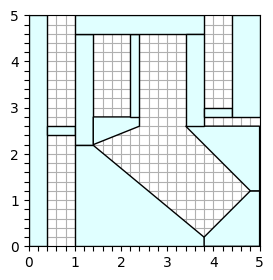

In [4]:
environment_setup()

for V in vertices:
    plt.fill(*V.T, fc='lightcyan', ec='k', zorder=4)

if savefig:
    plt.savefig('decomposition.pdf', bbox_inches='tight')

# Minimum-distance problem

In [5]:
def plot_trajectory(waypoints):

    plt.figure(figsize=(3, 3))

    for O in obstacles:
        plt.fill(*O.T, fc='lightcoral', ec='k', zorder=4)

    plt.plot(*x_start, 'kx')
    plt.plot(*x_goal, 'kx')
    plt.plot(*waypoints, 'b', zorder=5)

    plt.axis('square')
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    plt.xticks(range(6))
    plt.yticks(range(6))
    plt.grid(1)

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=false and rounding.
INFO:drake:Finished 100 rounding trials.


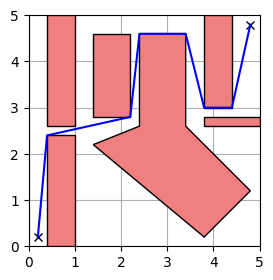

In [6]:
relaxation = True
gcs = LinearGCS(regions)
gcs.addSourceTarget(x_start, x_goal)
gcs.setSolver(MosekSolver())
waypoints = gcs.SolvePath(relaxation)[0]
plot_trajectory(waypoints)
if savefig:
    plt.savefig('linear.pdf', bbox_inches='tight')

# Minimum-time problem

In [7]:
qdot_min = -1
qdot_max = 1
n_samples = 500

def solve_bezier(order, continuity, regularizer=None, hdot_min=1e-6, velocity=None):
    
    gcs = BezierGCS(regions, order, continuity, hdot_min=hdot_min)

    gcs.addTimeCost(1)
    gcs.addVelocityLimits([qdot_min] * 2, [qdot_max] * 2)
    if regularizer is not None:
        gcs.addDerivativeRegularization(*regularizer, 2)
    gcs.addSourceTarget(x_start, x_goal, velocity=velocity)
    
    gcs.setSolver(MosekSolver())
    gcs.setPaperSolverOptions()
    
    traj = gcs.SolvePath(relaxation, verbose=True)[0]
    times = np.linspace(traj.start_time(), traj.end_time(), n_samples)
    waypoints = np.squeeze([traj.value(t) for t in times]).T
    velocities = np.squeeze([traj.EvalDerivative(t) for t in times]).T

    return waypoints, velocities, times

In [8]:
def plot_velocity(velocities, times, tol=np.inf):
    
    def plot_with_jumps(velocities, color):
        for i in range(len(times) - 1):
            dv = velocities[i + 1] - velocities[i]
            style = '-' if abs(dv) < tol else ':'
            plt.plot(times[i:i+2], velocities[i:i+2], color=color, linestyle=style)
            
    plt.figure(figsize=(3, 2))
            
    plot_with_jumps(velocities[0], 'tab:blue')
    plot_with_jumps(velocities[1], 'tab:orange')

    plt.xlim([times[0], times[-1]])
    plt.xticks(np.arange(int(np.ceil(times[-1] / 2))) * 2)
    plt.yticks(np.linspace(qdot_min, qdot_max, 5))
    plt.xlabel('Time $t$')
    plt.ylabel('Velocity $\dot{q}$')
    plt.grid()

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=false and no rounding.


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=false and rounding.
INFO:drake:Finished 100 rounding trials.


Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : LO (linear optimization problem)
  Constraints            : 1541            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 411             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 295
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 21
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 2               
Presolve term

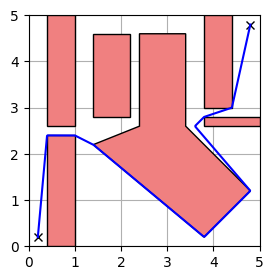

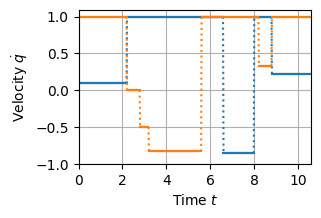

In [9]:
order = 1
continuity = 0
waypoints, velocities, times = solve_bezier(order, continuity)

plot_trajectory(waypoints)
if savefig:
    plt.savefig('bezier_10.pdf', bbox_inches='tight')

plot_velocity(velocities, times, tol=1e-1)
if savefig:
    plt.savefig('bezier_10_vel.pdf', bbox_inches='tight')

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=false and rounding.
INFO:drake:Finished 1 rounding trials.


Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5558            
  Affine conic cons.     : 290             
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 1571            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 946
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 123
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 2               
Presolve t

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x709b5b915e50>>
Traceback (most recent call last):
  File "/home/samuelbuckner/code/drake/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

  File "/home/samuelbuckner/anaconda3/lib/python3.11/bdb.py", line 92, in trace_dispatch
    return self.dispatch_call(frame, arg)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samuelbuckner/anaconda3/lib/python3.11/bdb.py", line 137, in dispatch_call
    if self.quitting: raise BdbQuit
                      ^^^^^^^^^^^^^
bdb.BdbQuit: 


Added (source, v0) to path.
Added (v0, v1) to path.
Added (v1, v2) to path.
Added (v2, v6) to path.
Added (v6, v9) to path.
Added (v9, v10) to path.
Added (v10, v11) to path.
Added (v11, target) to path.


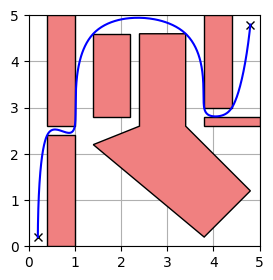

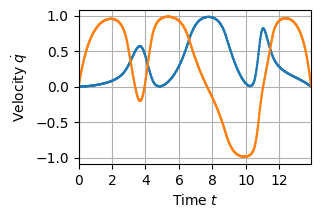

In [19]:
order = 6
continuity = 2
velocity = np.zeros((2, 2))
regularizer = [1e-1, 1e-1]
hdot_min = 1e-1
waypoints, velocities, times = solve_bezier(order, continuity, regularizer, hdot_min, velocity=velocity)

plot_trajectory(waypoints)
if savefig:
    plt.savefig('bezier_62.pdf', bbox_inches='tight')

plot_velocity(velocities, times)
if savefig:
    plt.savefig('bezier_62_vel.pdf', bbox_inches='tight')